In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Objective

# Data Loading

In [ ]:
data = pd.read_csv('airline-passenger-traffic.csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


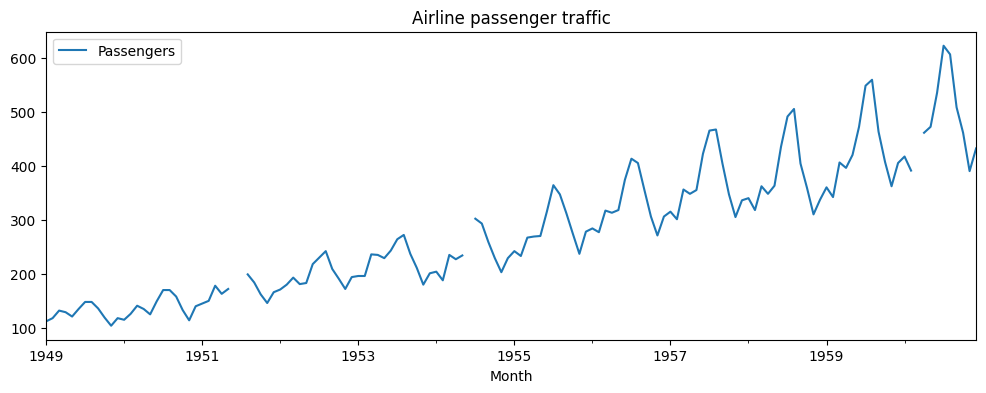

In [ ]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

# Handling Missing Values

Linear Interpolation for Missing Value Imputation

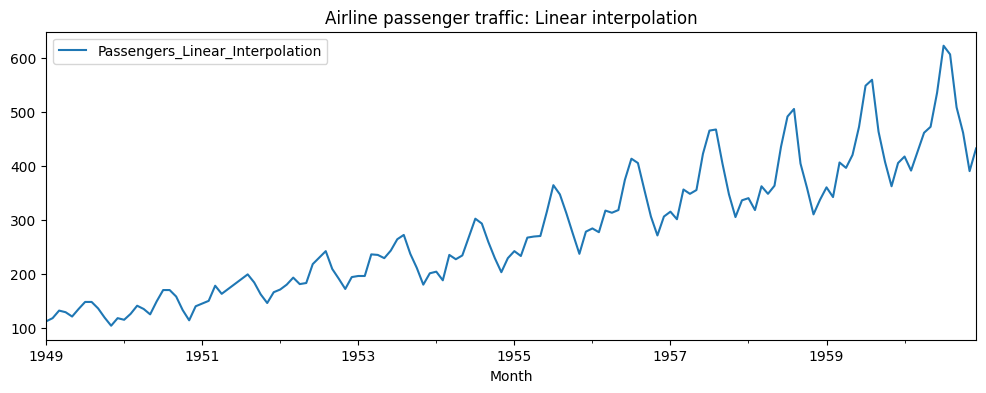

In [ ]:
data = data.assign(Passengers_Linear_Interpolation=data.Passengers.interpolate(method='linear'))
data[['Passengers_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Airline passenger traffic: Linear interpolation')
plt.show(block=False)

In [ ]:
data['Passengers'] = data['Passengers_Linear_Interpolation']
data.drop(columns=['Passengers_Linear_Interpolation'],inplace=True)

# Time Series Decomposition

Additive Seasonal Decomposition

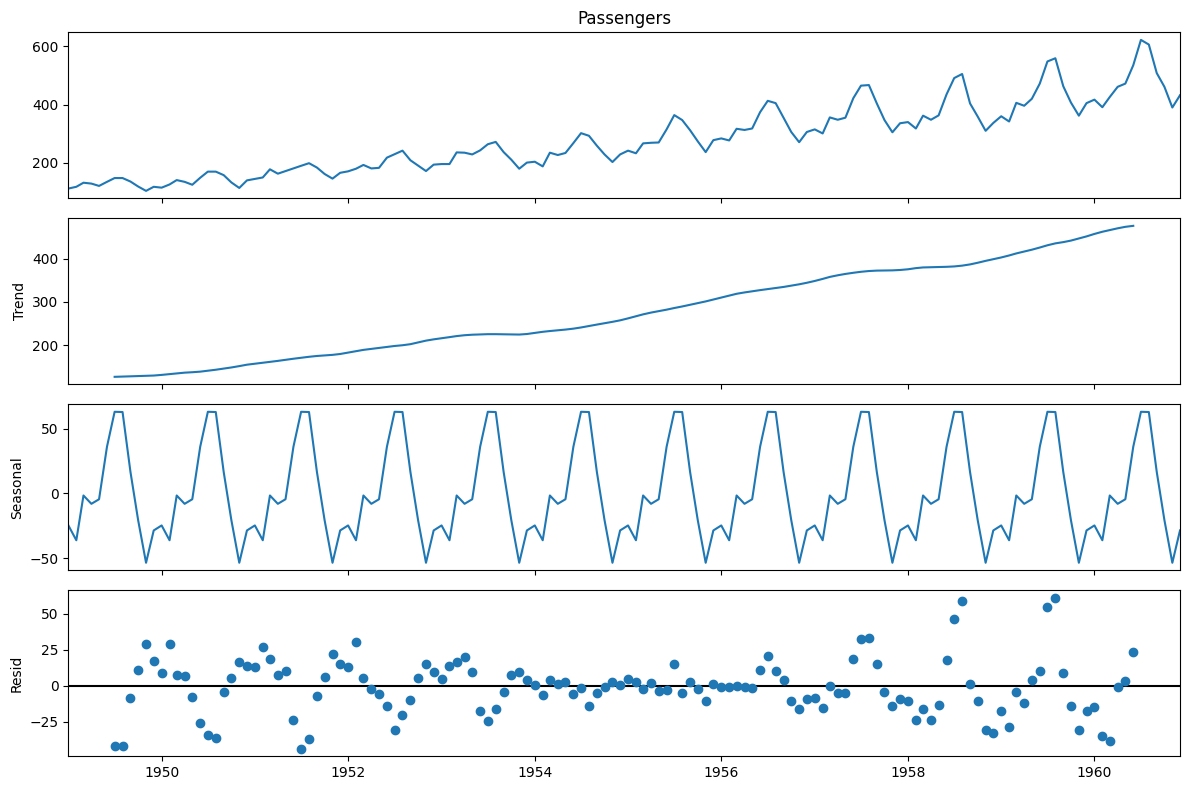

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

Multiplicative Seasonal Decomposition

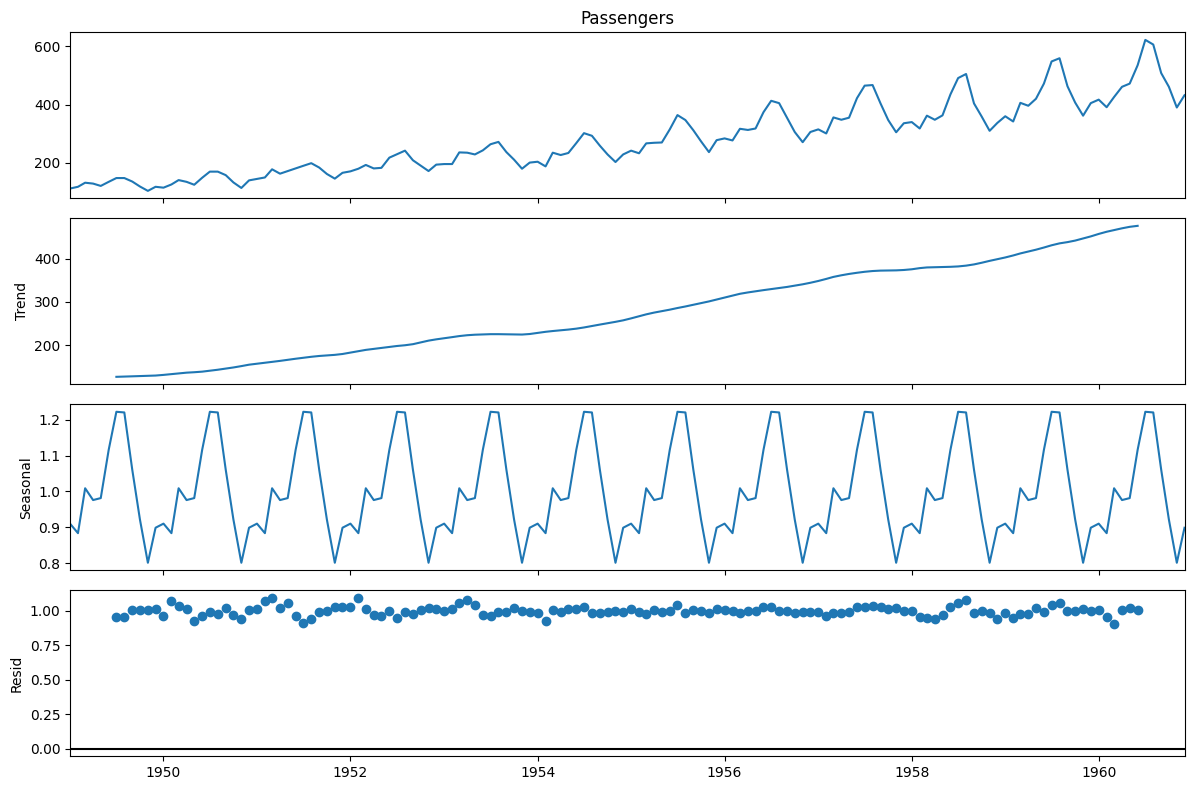

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

# Splitting Time Series Data in Train and Test Sets

In [ ]:
train_len = 120
train = data[0:train_len]
test = data[train_len:]

# Stationarity Tests

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train['Passengers'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -0.601342
Critical Values @ 0.05: -2.89
p-value: 0.870678


In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(train['Passengers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.706343
Critical Values @ 0.05: 0.46
p-value: 0.010000


Boxcox transformation to make variance constant.

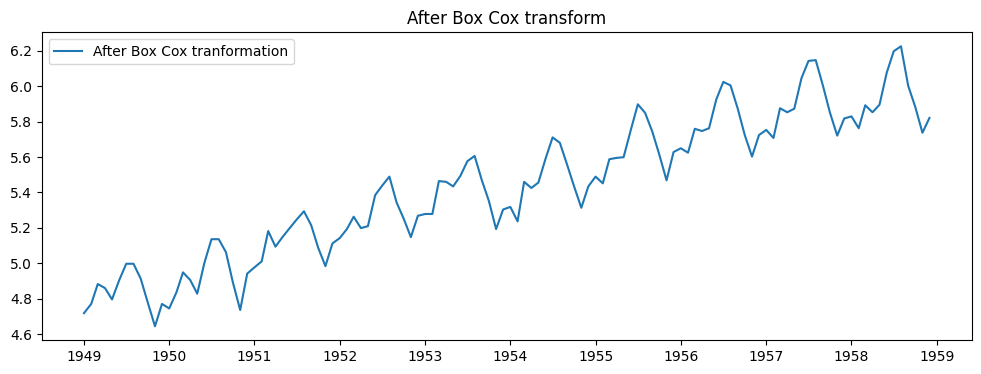

In [ ]:
from scipy.stats import boxcox

lmbda=0

train_boxcox = pd.Series(boxcox(train['Passengers'], lmbda=lmbda), index = train.index)

plt.figure(figsize=(12,4))
plt.plot(train_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

BoxCox transformation on test data with same lambda as 0

In [ ]:
test_boxcox = pd.Series(boxcox(test['Passengers'], lmbda=lmbda), index = test.index)

First Order Differencing

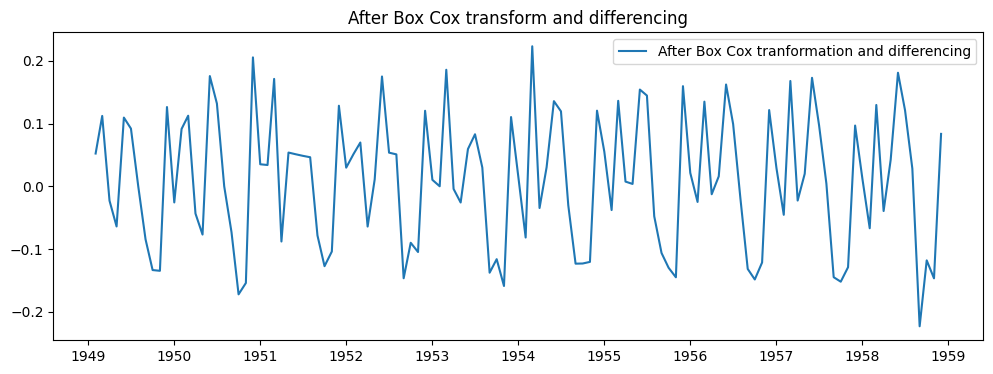

In [ ]:
train_boxcox_diff = pd.Series(train_boxcox - train_boxcox.shift(), train.index)
plt.figure(figsize=(12,4))
plt.plot(train_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
test_boxcox_diff = pd.Series(test_boxcox - test_boxcox.shift(), test.index)

In [ ]:
train_boxcox_diff=train_boxcox_diff.dropna()
test_boxcox_diff=test_boxcox_diff.dropna()

Again stationarity test

In [ ]:
adf_test = adfuller(train_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.629029
Critical Values @ 0.05: -2.89
p-value: 0.087145


In [ ]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(train_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.029650
Critical Values @ 0.05: 0.46
p-value: 0.100000


# ACF and PCF

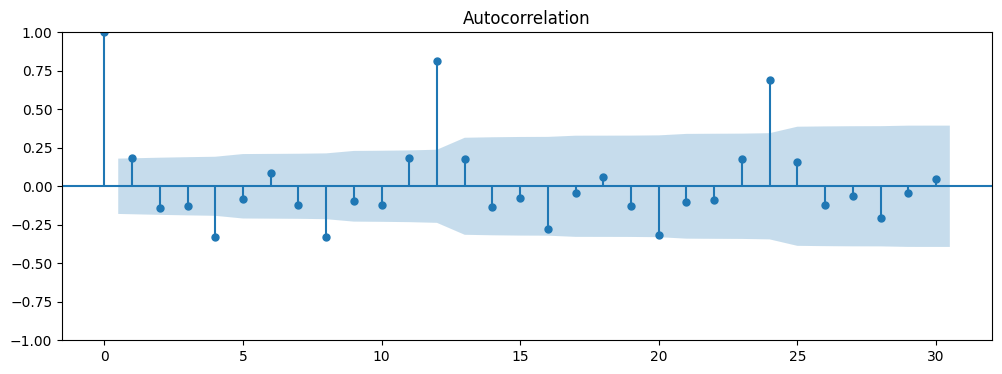

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

q=1

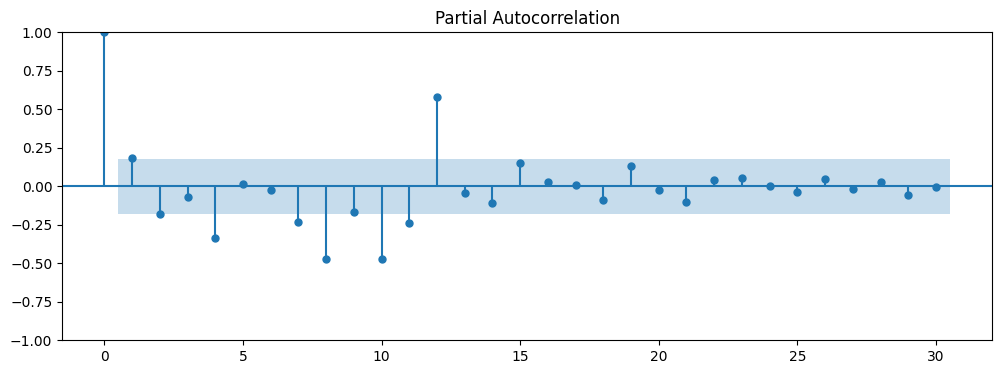

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

p=1

# ARMA Model

In [ ]:
model0 = ARIMA(train_boxcox_diff, order=(1, 0, 1))
model_fit0 = model0.fit()
print(model_fit0.params)

const     0.009618
ar.L1    -0.527079
ma.L1     0.798271
sigma2    0.010051
dtype: float64


In [ ]:
#y_hat_arma = data_boxcox_diff.copy()
# y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
# y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
# y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

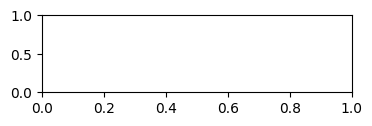

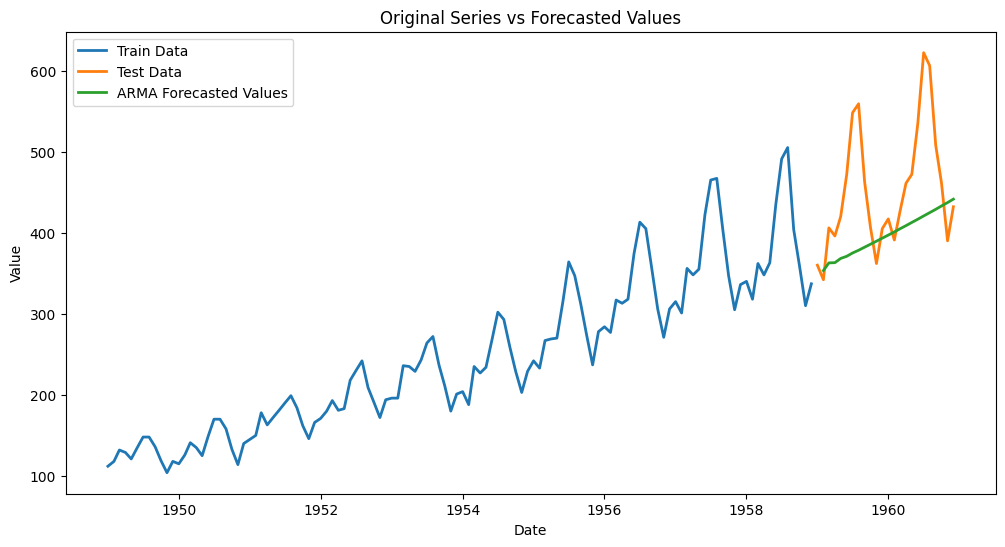

In [ ]:
forecast_diff0 = model_fit0.predict(start=train_boxcox_diff.index[0], end=test_boxcox_diff.index[-1])
forecast_diff0 = forecast_diff0.cumsum()
forecast_boxcox0 = forecast_diff0 + train_boxcox.iloc[0]
forecast_original0 = np.exp(forecast_boxcox0)

plt.figure(figsize=(12, 6))

# # Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# # Plot the original test data (optional, can be used to show actual test values)
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
# #plt.plot(train.index, forecast_original[:len(train)], color='orange', label='ARIMA Forecasted Values', linewidth=2)
plt.plot(forecast_original0[len(train):], label='ARMA Forecasted Values', linewidth=2)


# plt.figure(figsize=(12,4))
# plt.plot( data['Passengers'][:train_len-1], label='Train')
# plt.plot(data['Passengers'][train_len-1:], label='Test')
# plt.plot(forecast_original[test.index.min():], label='ARMA forecast')
# plt.legend(loc='best')
# plt.title('ARMA Method')
# plt.show()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()

# Show the plot
plt.show()

In [ ]:
forecast_diff0

,predicted_mean
1949-02-01,0.009618
1949-03-01,0.027639
1949-04-01,0.054167
1949-05-01,0.042795
1949-06-01,0.050095
...,...
1960-08-01,1.333012
1960-09-01,1.342630
1960-10-01,1.352248
1960-11-01,1.361865


In [ ]:
forecast_diff

,predicted_mean
1949-02-01,4.718499
1949-03-01,9.499599
1949-04-01,14.400305
1949-05-01,19.240678
1949-06-01,24.035152
...,...
1960-08-01,763.174204
1960-09-01,769.035373
1960-10-01,774.896542
1960-11-01,780.757711


# ARIMA Model

In [ ]:
model = ARIMA(train_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

ar.L1    -0.522043
ma.L1     0.796153
sigma2    0.010117
dtype: float64


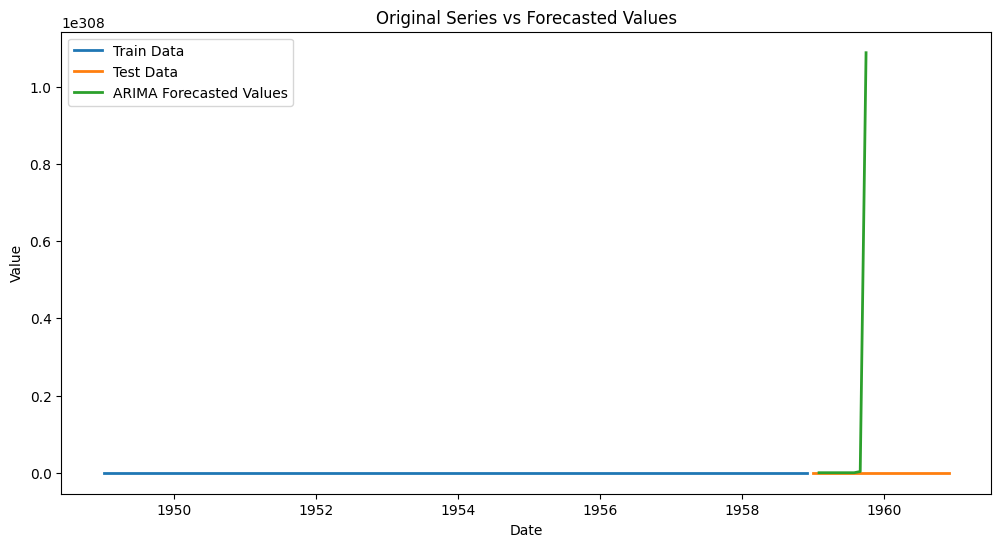

In [ ]:
forecast_diff = model_fit.predict(start=train_boxcox_diff.index[0], end=test_boxcox_diff.index[-1])
forecast_diff = forecast_diff.cumsum()
forecast_boxcox = forecast_diff + train_boxcox.iloc[0]
forecast_original = np.exp(forecast_boxcox)


plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data (optional, can be used to show actual test values)
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
plt.plot(forecast_original[len(train):], label='ARIMA Forecasted Values', linewidth=2)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()

# Show the plot
plt.show()

# SARIMA Model

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
stepwise_fit = auto_arima(train_boxcox, start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise

# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-386.402, Time=0.75 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-356.096, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-380.632, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-386.621, Time=0.63 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-361.922, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-384.837, Time=3.68 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-384.837, Time=2.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-382.837, Time=0.37 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-382.884, Time=2.68 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-380.656, Time=0.33 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-385.546, Time=0.91 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-385.260, Time=0.39 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-384.573, Time=1.72 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-384.794, Time=1.33 sec

Best model:  ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 196.311
Date:                            Tue, 28 Jan 2025   AIC                           -386.621
Time:                                    20:39:24   BIC                           -378.603
Sample:                                01-01-1949   HQIC                          -383.371
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3092      0.090     -3.437      0.001      -0.486      -0.133
ma.S.L12      -0.5381      0.106     -5.071      0.000      -0.746      -0.330
sigma2         0.0014      0.000      7.784      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.76   Prob(JB):                         0.76
Heteroskedasticity (H):               0.34   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = SARIMAX(train_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.382256
ma.L1      -0.675219
ar.S.L12   -0.039920
ma.S.L12   -0.516744
sigma2      0.001412
dtype: float64


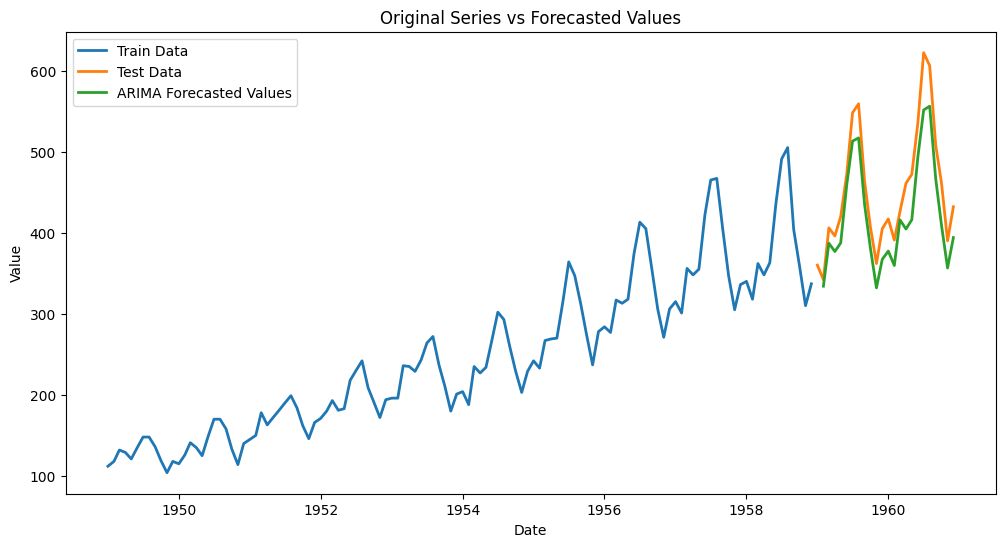

In [ ]:
forecast_diff3 = model_fit.predict(start=train_boxcox_diff.index[0], end=test_boxcox_diff.index[-1])
forecast_original = np.exp(forecast_diff3)

plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data (optional, can be used to show actual test values)
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
plt.plot(forecast_original[len(train):], label='ARIMA Forecasted Values', linewidth=2)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
model = SARIMAX(train_boxcox, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ma.L1      -0.309236
ma.S.L12   -0.538094
sigma2      0.001435
dtype: float64


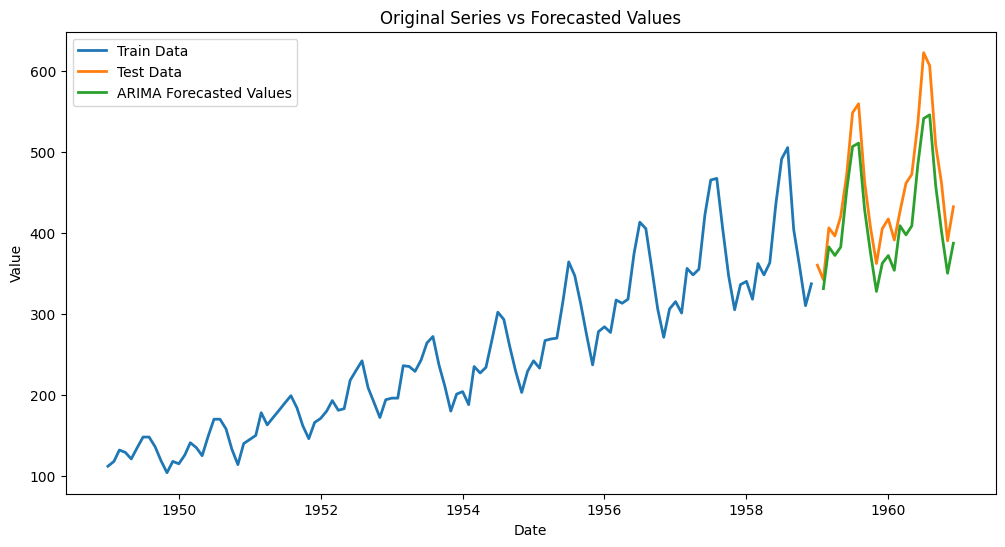

In [ ]:
forecast_diff3 = model_fit.predict(start=train_boxcox_diff.index[0], end=test_boxcox_diff.index[-1])
forecast_original = np.exp(forecast_diff3)

plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data (optional, can be used to show actual test values)
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
plt.plot(forecast_original[len(train):], label='ARIMA Forecasted Values', linewidth=2)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()

# Show the plot
plt.show()


# SARIMAX

In [ ]:
promo = pd.read_csv('promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
...,...
1960-08-01,1
1960-09-01,1
1960-10-01,1


In [ ]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [ ]:
model = SARIMAX(train_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train)
model_fit = model.fit()
print(model_fit.params)

Event       0.034356
ar.L1       0.481182
ma.L1      -0.743378
ar.S.L12   -0.064583
ma.S.L12   -0.557249
sigma2      0.001334
dtype: float64


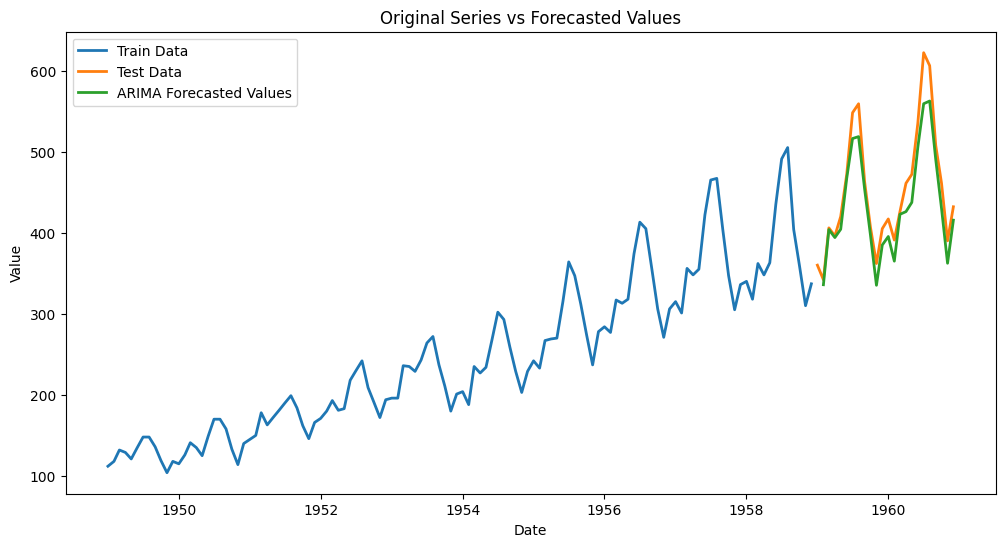

In [ ]:
forecast_diff3 = model_fit.predict(start=train_boxcox_diff.index[0], end=test_boxcox_diff.index[-1], exog=promo_test)
forecast_original = np.exp(forecast_diff3)

plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data (optional, can be used to show actual test values)
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
plt.plot(forecast_original[len(train):], label='ARIMA Forecasted Values', linewidth=2)


# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sarimax['sarimax_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers']-y_hat_sarimax['sarimax_forecast'][test.index.min():])/test['Passengers'])*100,2)